# Molecular Dynamics: Protein-Ligand

Before continue, you should have:

- installed GROMACS
- put CHARMM36 force field in the correct location

In [1]:
import os

os.environ['PATH'] = '/usr/local/gromacs/bin:' + os.environ['PATH']

In [2]:
from pathlib import Path
from matplotlib.ticker import ScalarFormatter
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
PROTEIN_CLS = "RAS"
PROTEIN_SID = "FM13"
LIGAND_ID = "GDP"
COMPLEX_ID = f"{PROTEIN_SID}-{LIGAND_ID}"
COMPLEX_PDB = Path(f"../docking/wd/RAS/FM13-GDP/FM13-GDP.docked.01.pdb")

# Create a new working directory!
WD = Path(f"wd-md2/{PROTEIN_CLS}/{COMPLEX_ID}")
WD.mkdir(parents=True, exist_ok=True)

# TOOLS: Change the path accordingly
GROMACS_PATH = "~/WS/ProtMatch/gromacs"

We then need to prepare the protein topology and the ligand topology separately.

1. If you start with a PDB file of a complex, you may want to strip out the crystal waters and unwanted ligands.
   Replace UNL in files with your correct ligand name.

In [4]:
!cp {COMPLEX_PDB} {WD}/{COMPLEX_PDB.name}
COMPLEX_PDB = Path(COMPLEX_PDB.name)

LIGAND_PDB = Path(f"{LIGAND_ID}.pdb")
PROTEIN_PDB = Path(f"{PROTEIN_SID}.pdb")

# ligand
!cd {WD} && grep UNL {COMPLEX_PDB} > {LIGAND_PDB}
# !cd {WD} && grep {LIGAND_ID} {COMPLEX_PDB} > {LIGAND_PDB}
# protein
!cd {WD} && grep -v UNL {COMPLEX_PDB} > {PROTEIN_PDB}.tmp
# !cd {WD} && grep -v HETATM {COMPLEX_PDB} > {PROTEIN_PDB}.tmp
!cd {WD} && grep -v CONECT {PROTEIN_PDB}.tmp > {PROTEIN_PDB}
!cd {WD} && rm -f {PROTEIN_PDB}.tmp

del COMPLEX_PDB

2. Or you have already prepared seperated PDB files for protein and its ligand, just specify the paths.

    If you are simulating generated structures, make sure you have
    - predicted the sequence of the generated structure
    - modelled and added side chains to the structure

In [5]:
# PROTEIN_PDB = f"{PROTEIN_SID}.pdb"

## Protein Topology with CHARMM36 Force Field

In [6]:
PROTEIN_GRO = Path(f"{PROTEIN_SID}.gro")
PROTEIN_TOP = Path(f"{PROTEIN_SID}.top")
FF_PATH = Path("../../gromacs/charmm36-jul2022.ff")
!cp -r {FF_PATH} {WD}
!cd {WD} && gmx pdb2gmx -f {PROTEIN_PDB} -o {PROTEIN_GRO} -p {PROTEIN_TOP} -water tip3p -ff charmm36-jul2022 -ignh
# Any errors check https://manual.gromacs.org/2021.4/user-guide/run-time-errors.html.
# If a fatal error occurred due to H, this atom may not defined in the FF.
# Consider to remove this atom from PDB, or (not recommended) ignore hydrogen atoms with `-ignh`.
# If atom C1 not found in buiding block 1MET while combining tdb and rtp, you may need `-ter`.
# Check more at https://gromacs.bioexcel.eu/t/newest-charmm36-port-for-gromacs/868/11.

                     :-) GROMACS - gmx pdb2gmx, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/PROTEVAL/notebooks/dynamics/wd-md2/RAS/FM13-GDP
Command line:
  gmx pdb2gmx -f FM13.pdb -o FM13.gro -p FM13.top -water tip3p -ff charmm36-jul2022 -ignh

Using the Charmm36-jul2022 force field in directory ./charmm36-jul2022.ff

going to rename ./charmm36-jul2022.ff/aminoacids.r2b
Opening force field file ./charmm36-jul2022.ff/aminoacids.r2b

going to rename ./charmm36-jul2022.ff/carb.r2b
Opening force field file ./charmm36-jul2022.ff/carb.r2b

going to rename ./charmm36-jul2022.ff/cgenff.r2b
Opening force field file ./charmm36-jul2022.ff/cgenff.r2b

going to rename ./charmm36-jul2022.ff/ethers.r2b
Opening force field file ./charmm36-jul2022.ff/ethers.r2b

going to rename ./charmm36-jul2022.ff/lipid.r2b
Opening force field file ./charmm36-jul2022.ff/lipid.r2b

going to rename ./charmm36-jul2022.ff/metals.r2b
Opening force fiel

You may want to move the protein and its ligand(s) to the origin before continue.

## Ligand Topology

Refer to http://www.mdtutorials.com/gmx/complex/.

1. Add hydrogen atoms and convert <ligand>.sdf to <ligand>.mol2, using tools like openbabel or Avogadro.
2. Fix the residue names and numbers.
   Use sort_mol2_bonds.pl (http://www.mdtutorials.com/gmx/complex/Files/sort_mol2_bonds.pl) to sort bonds in ascending order.
3. Generate the ligand topology with the CGenFF server. [https://app.cgenff.com/homepage]
   CGenFF server will return a topology in the form of a CHARMM "stream" file (.str).
   Save its contents into a file called <ligand>.str.
4. Convert CHARMM stream file to GROMACS format.
   https://github.com/Lemkul-Lab/cgenff_charmm2gmx
   (You may need python 3.5 to run this script)

In [8]:
SORTMOL2 = "../../gromacs/sort_mol2_bonds.pl"
!cp {SORTMOL2} {WD}
!cd {WD} && perl sort_mol2_bonds.pl {LIGAND_ID}.mol2 {LIGAND_ID}.fix.mol2

Found 43 atoms in the molecule, with 45 bonds.


In [9]:
CHARMM2GMX = "../../gromacs/cgenff_charmm2gmx_py3_nx2.py"
!cp {CHARMM2GMX} {WD}
# In working directory, run the following with Python 3.5
# python cgenff_charmm2gmx_py3_nx2.py GDP GDP.mol2 GDP.str charmm36-jul2022.ff

## Build the Complex

In [10]:
LIGAND_GRO = f"{LIGAND_ID}.gro"
# change *_ini.pdb accordingly
!cd {WD} && gmx editconf -f {LIGAND_ID.lower()}_ini.pdb -o {LIGAND_GRO}

                     :-) GROMACS - gmx editconf, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/PROTEVAL/notebooks/dynamics/wd-md2/RAS/FM13-GDP
Command line:
  gmx editconf -f gdp_ini.pdb -o GDP.gro

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 43 atoms
No velocities found

See the GROMACS manual for a description of the requirements that
must be satisfied by descriptions of simulation cells.

GROMACS reminds you: "Only entropy comes easy." (Anton Chekov)



In [11]:
COMPLEX_GRO = "complex.gro"
!cd {WD} && cp {PROTEIN_GRO} complex.gro

(see more in http://www.mdtutorials.com/gmx/complex/02_topology.html)
1. Copy <protein>.gro to a new file complex.gro
2. Copy the coordinate section of <ligand>.gro and paste it into complex.gro
3. Increment the second line of complex.gro to reflect this change.

## Build the Topology
1. Insert line `#include "<ligand>.itp"` into <protein>.top after the position restraint file is included.

   ```
   ; Include Position restraint file
    #ifdef POSRES
    #include "posre.itp"
    #endif
    
    ; Include ligand topology <-- ADD
    #include "<ligand>.itp" <-- ADD
    
    ; Include water topology
    #include "./charmm36-jul2022.ff/tip3p.itp"
    ```
   
2. At the TOP of <protein>.top, insert an #include statement to add these parameters:

   ```
   ; Include forcefield parameters
    #include "./charmm36-jul2022.ff/forcefield.itp"
    
    ; Include ligand parameters <-- ADD
    #include "<ligand>.prm" <-- ADD
    
    [ moleculetype ]
    ; Name            nrexcl
    Protein_chain_A     3
   ```

3. At the END of <protein>.top, insert

   ```
   [ molecules ]
   ; Compound        #mols
   Protein_chain_A     1
   GDP                 1 <-- ADD
   ```

## Setting Up the Simulation Box and Solvating the System

In [12]:
BOX_GRO = "box.gro"
!cd {WD} && gmx editconf -f {COMPLEX_GRO} -o {BOX_GRO} -c -d 1.5 -bt octahedron

                     :-) GROMACS - gmx editconf, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/PROTEVAL/notebooks/dynamics/wd-md2/RAS/FM13-GDP
Command line:
  gmx editconf -f complex.gro -o box.gro -c -d 1.5 -bt octahedron

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 2778 atoms
Volume: 86.1206 nm^3, corresponds to roughly 38700 electrons
No velocities found
    system size :  4.263  4.370  4.623 (nm)
    diameter    :  5.034               (nm)
    center      :  0.040  0.020 -0.012 (nm)
    box vectors :  4.263  4.371  4.622 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :  86.12               (nm^3)
    shift       :  3.977  5.660  3.291 (nm)
new center      :  4.017  5.681  3.280 (nm)
new box vectors :  8.034  8.034  8.034 (nm)
new box angles  :  70.53 109.47  70.53 (degrees)
new box volume  : 399.12               (nm^3)

GROMACS reminds y

In [13]:
SOLV_GRO = "solv.gro"
!cd {WD} && gmx solvate -cp {BOX_GRO} -cs spc216.gro -p {PROTEIN_TOP} -o {SOLV_GRO}

                     :-) GROMACS - gmx solvate, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/PROTEVAL/notebooks/dynamics/wd-md2/RAS/FM13-GDP
Command line:
  gmx solvate -cp box.gro -cs spc216.gro -p FM13.top -o solv.gro

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

+

## Adding Ions

In [14]:
IONS_TPR = "ions.tpr"
MIN_SD_MDP = Path(GROMACS_PATH) / "min_sd.mdp"
!cd {WD} && gmx grompp -f {MIN_SD_MDP} -c {SOLV_GRO} -p {PROTEIN_TOP} -o {IONS_TPR} -maxwarn 1

                      :-) GROMACS - gmx grompp, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/PROTEVAL/notebooks/dynamics/wd-md2/RAS/FM13-GDP
Command line:
  gmx grompp -f /home/tz365/WS/ProtMatch/gromacs/min_sd.mdp -c solv.gro -p FM13.top -o ions.tpr -maxwarn 1

Ignoring obsolete mdp entry 'ns_type'
Setting the LD random seed to 804249341

Generated 167799 of the 167910 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 3 bonded neighbours molecule type 'GDP'

Excluding 2 bonded neighbours molecule type 'SOL'

NOTE 1 [file FM13.top, line 25940]:
  System has non-zero total charge: -2.000000
  Total charge should normally be an integer. See
  https://manual.gromacs.org/current/user-guide/floating-point.html
  for discussion on how close it should be to an integer.



In [15]:
SOLV_IONS_GRO = "solv_ions.gro"
!cd {WD} && echo SOL | gmx genion -s {IONS_TPR} -o {SOLV_IONS_GRO} -conc 0.15 -pname NA -nname CL -neutral -p {PROTEIN_TOP}

                      :-) GROMACS - gmx genion, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/PROTEVAL/notebooks/dynamics/wd-md2/RAS/FM13-GDP
Command line:
  gmx genion -s ions.tpr -o solv_ions.gro -conc 0.15 -pname NA -nname CL -neutral -p FM13.top

Reading file ions.tpr, VERSION 2024.2 (single precision)
Reading file ions.tpr, VERSION 2024.2 (single precision)
Will try to add 38 NA ions and 36 CL ions.
Select a continuous group of solvent molecules
Group     0 (         System) has 39588 elements
Group     1 (        Protein) has  2735 elements
Group     2 (      Protein-H) has  1348 elements
Group     3 (        C-alpha) has   170 elements
Group     4 (       Backbone) has   510 elements
Group     5 (      MainChain) has   679 elements
Group     6 (   MainChain+Cb) has   839 elements
Group     7 (    MainChain+H) has   844 elements
Group     8 (      SideChain) has  1891 elements
Group     9 (    SideChain-H) has  

## Energy Minimization

In [16]:
EM_TPR = "em.tpr"
!cd {WD} && gmx grompp -v -f {MIN_SD_MDP} -c {SOLV_IONS_GRO} -p {PROTEIN_TOP} -o {EM_TPR}

                      :-) GROMACS - gmx grompp, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/PROTEVAL/notebooks/dynamics/wd-md2/RAS/FM13-GDP
Command line:
  gmx grompp -v -f /home/tz365/WS/ProtMatch/gromacs/min_sd.mdp -c solv_ions.gro -p FM13.top -o em.tpr

Ignoring obsolete mdp entry 'ns_type'
checking input for internal consistency...

Setting the LD random seed to -67111041

processing topology...

Generated 167799 of the 167910 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 3 bonded neighbours molecule type 'GDP'

Excluding 2 bonded neighbours molecule type 'SOL'

Excluding 3 bonded neighbours molecule type 'NA'

Excluding 3 bonded neighbours molecule type 'CL'

processing coordinates...

double-checking input for internal consistency...
renumbering atomtyp

In [17]:
!cd {WD} && gmx mdrun -v -deffnm {Path(EM_TPR).stem} -c {SOLV_IONS_GRO} -gpu_id 0

                      :-) GROMACS - gmx mdrun, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/PROTEVAL/notebooks/dynamics/wd-md2/RAS/FM13-GDP
Command line:
  gmx mdrun -v -deffnm em -c solv_ions.gro -gpu_id 0

Reading file em.tpr, VERSION 2024.2 (single precision)
1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the CPU
Using 1 MPI thread
Using 24 OpenMP threads 


Steepest Descents:
   Tolerance (Fmax)   =  2.00000e+00
   Number of steps    =        30000
Step=    0, Dmax= 1.0e-02 nm, Epot= -1.98396e+05 Fmax= 2.35711e+06, atom= 1861
Step=    1, Dmax= 1.0e-02 nm, Epot= -2.22785e+05 Fmax= 2.04889e+05, atom= 1861
Step=    2, Dmax= 1.2e-02 nm, Epot= -2.88359e+05 Fmax= 7.09257e+04, atom= 26041
Step=    3, Dmax= 1.4e-02 nm, Epot= -3.48604e+05 Fmax= 2.56720

                      :-) GROMACS - gmx energy, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/PROTEVAL/notebooks/dynamics/wd-md2/RAS/FM13-GDP
Command line:
  gmx energy -f em.edr -o em.xvg -xvg none

Opened em.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pressure      
 13  Vir-XX          14  Vir-XY          15  Vir-XZ          16  Vir-YX        
 17  Vir-YY          18  Vir-YZ          19  Vir-ZX          20  Vir-ZY        
 21  Vir-ZZ          22  Pres-XX         23  P

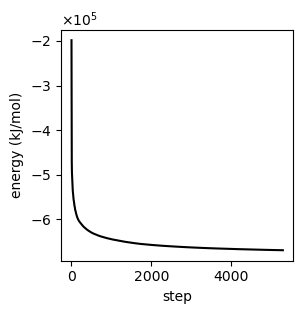

In [18]:
EM_EDR = "em.edr"
EM_XVG = "em.xvg"
!cd {WD} && echo "11" | gmx energy -f {EM_EDR} -o {EM_XVG} -xvg none

fig, ax = plt.subplots(figsize=(3, 3))
df = pd.read_csv(WD / EM_XVG, sep='\s+', header=None, names=['step', 'energy'])
plt.plot(df["step"], df["energy"], color="black")
plt.xlabel("step")
plt.ylabel("energy (kJ/mol)")
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.grid(False)
plt.show()

## Restraining the Ligand

1. Generate a position restraint topology for the ligand. 
   First, create an index group for the ligand that contains only its non-hydrogen atoms:

In [ ]:
stop!

In [21]:
RES_LIGAND_NDX = f"{LIGAND_ID}.res.ndx"
options = "0 & ! a H*\nq\n"
!cd {WD} && echo gmx make_ndx -f {LIGAND_GRO} -o {RES_LIGAND_NDX}

gmx make_ndx -f GDP.gro -o GDP.res.ndx


2. Execute the genrestr module and select this newly created index group.

In [ ]:
stop

In [22]:
RES_LIGAND_ITP = f"{LIGAND_ID.lower()}.res.itp"
options = "2" # for Group 2 (Ligand)
!cd {WD} && echo {options} | gmx genrestr -f {LIGAND_GRO} -n {RES_LIGAND_NDX} -o {RES_LIGAND_ITP} -fc 1000 1000 1000

                     :-) GROMACS - gmx genrestr, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/PROTEVAL/notebooks/dynamics/wd-md2/RAS/FM13-GDP
Command line:
  gmx genrestr -f GDP.gro -n GDP.res.ndx -o gdp.res.itp -fc 1000 1000 1000


Reading structure file
Select group to position restrain
Group     0 (         System) has    43 elements
Group     1 (          Other) has    43 elements
Group     2 (            GDP) has    43 elements
Group     3 (   System_&_!H*) has    28 elements
Select a group: Selected 2: 'GDP'

GROMACS reminds you: "Keep Your Shoes and Socks On, People" (F. Zappa)



3. Include this information in the topology <protein>.top
   If we simply want to restrain the ligand whenever the protein is also restrained, add the following lines to the topology in the location indicated:
   ```
    ; Include ligand topology
    #include "gdp.itp"
    
    ; Ligand position restraints <--
    #ifdef POSRES <--
    #include "gdp.res.itp" <--
    #endif <--
    
    ; Include water topology
    #include "./charmm36-jul2022.ff/tip3p.itp"
   ```
   
## Thermostats

Do not couple every single species in your system separately.

Since <ligand> and the protein are physically linked very tightly, it is best to consider them as a single entity. 

In [23]:
THERMOSTATS_NDX = "thermostats.ndx"
# Typical options: Protein | <ligand>
!cd {WD} && echo gmx make_ndx -f {SOLV_IONS_GRO} -o {THERMOSTATS_NDX} # remove echo

gmx make_ndx -f solv_ions.gro -o thermostats.ndx


Set `tc-grps = Protein_<ligand> Water_and_ions`.

## NVT Equlibration

In [24]:
NVT_MDP = Path("../../gromacs/nvt.gdp.mdp")
!cp {NVT_MDP} {WD}

NVT_MDP = NVT_MDP.name
NVT_NN = f"{PROTEIN_PDB.stem}_NVT"
NVT_TPR = Path(f"{NVT_NN}.tpr")

!cd {WD} && gmx grompp -v -f {NVT_MDP} -c {SOLV_IONS_GRO} -r {SOLV_IONS_GRO} -p {PROTEIN_TOP} -n {THERMOSTATS_NDX} -o {NVT_TPR}
!cd {WD} && gmx mdrun -v -deffnm {NVT_NN} -s {NVT_TPR} -gpu_id 0

                      :-) GROMACS - gmx grompp, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/PROTEVAL/notebooks/dynamics/wd-md2/RAS/FM13-GDP
Command line:
  gmx grompp -v -f nvt.gdp.mdp -c solv_ions.gro -r solv_ions.gro -p FM13.top -n thermostats.ndx -o FM13_NVT.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
checking input for internal consistency...

Setting the LD random seed to -1706528833

processing topology...

Generated 167799 of the 167910 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'GDP'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 b

## NPT Equilibration

In [25]:
NPT_MDP = Path("../../gromacs/npt.gdp.mdp")
!cp {NPT_MDP} {WD}

NPT_MDP = NPT_MDP.name
NPT_NN = f"{PROTEIN_PDB.stem}_NPT"
NPT_TPR = Path(f"{NPT_NN}.tpr")

!cd {WD} && gmx grompp -v -f {NPT_MDP} -c {NVT_NN}.gro -t {NVT_NN}.cpt -r {NVT_NN}.gro -p {PROTEIN_TOP} -n {THERMOSTATS_NDX} -o {NPT_TPR}
!cd {WD} && gmx mdrun -v -deffnm {NPT_NN} -s {NPT_TPR} -gpu_id 0

                      :-) GROMACS - gmx grompp, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/PROTEVAL/notebooks/dynamics/wd-md2/RAS/FM13-GDP
Command line:
  gmx grompp -v -f npt.gdp.mdp -c FM13_NVT.gro -t FM13_NVT.cpt -r FM13_NVT.gro -p FM13.top -n thermostats.ndx -o FM13_NPT.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
checking input for internal consistency...

Setting the LD random seed to -453256761

processing topology...

Generated 167799 of the 167910 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'GDP'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...



## Productin

In [26]:
PROD_MDP = Path("../../gromacs/prod.gdp.mdp")
!cp {PROD_MDP} {WD}

PROD_MDP = PROD_MDP.name
PROD_NN = f"{PROTEIN_PDB.stem}_PROD"
PROD_TPR = Path(f"{PROD_NN}.tpr")

!cd {WD} && gmx grompp -v -f {PROD_MDP} -c {NPT_NN}.gro -t {NPT_NN}.cpt -p {PROTEIN_TOP} -n {THERMOSTATS_NDX} -o {PROD_TPR}
!cd {WD} && gmx mdrun -v -deffnm {PROD_NN} -s {PROD_TPR} -gpu_id 0

                      :-) GROMACS - gmx grompp, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/PROTEVAL/notebooks/dynamics/wd-md2/RAS/FM13-GDP
Command line:
  gmx grompp -v -f prod.gdp.mdp -c FM13_NPT.gro -t FM13_NPT.cpt -p FM13.top -n thermostats.ndx -o FM13_PROD.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
checking input for internal consistency...

Setting the LD random seed to 1303894585

processing topology...

Generated 167799 of the 167910 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'GDP'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bo

In [27]:
!rm -rf {WD}/charmm36-nov2016.ff

In [28]:
MAX_TIME = 200  # You can get this from the previous command.
os.mkdir(WD / "trajectories")
for i, t in enumerate(range(0, MAX_TIME, 10)):
    !cd {WD} && printf "System" | gmx trjconv -s {PROD_TPR} -f {PROD_NN}.xtc -o trajectories/trj{i}.pdb -dump {t}

                     :-) GROMACS - gmx trjconv, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/PROTEVAL/notebooks/dynamics/wd-md2/RAS/FM13-GDP
Command line:
  gmx trjconv -s FM13_PROD.tpr -f FM13_PROD.xtc -o trajectories/trj0.pdb -dump 0

Note that major changes are planned in future for trjconv, to improve usability and utility.
Will write pdb: Protein data bank file
Reading file FM13_PROD.tpr, VERSION 2024.2 (single precision)
Reading file FM13_PROD.tpr, VERSION 2024.2 (single precision)
Select group for output
Group     0 (         System) has 39440 elements
Group     1 (        Protein) has  2735 elements
Group     2 (      Protein-H) has  1348 elements
Group     3 (        C-alpha) has   170 elements
Group     4 (       Backbone) has   510 elements
Group     5 (      MainChain) has   679 elements
Group     6 (   MainChain+Cb) has   839 elements
Group     7 (    MainChain+H) has   844 elements
Group     8 (      Si